In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#load the data
df = pd.read_csv(r'C:\Users\USER\Desktop\ab_test_data.xls')

In [3]:
df.head()

,user_id,click,group,timestamp
0,8afdde65-873f-4d53-9dd5-4a3608ed6b99,1,control,2024-11-29 23:59:53
1,aa134751-b8fe-435f-802a-fae26279625a,1,test,2024-07-20 11:55:07
2,18ed8e12-020c-49f7-baf8-2768e5c37d4f,0,control,2024-07-11 04:24:21
3,675be698-4195-47c2-8898-f38f3ff53fb9,1,test,2024-04-10 00:58:19
4,b9401e2b-067a-4546-9887-231f7504ffe4,0,control,2024-08-27 09:13:20


In [4]:
df.describe()

,click
count,10000.000000
mean,0.486300
std,0.499837
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [5]:
df.groupby("group").sum("click")

,click
group,
control,2399
test,2464


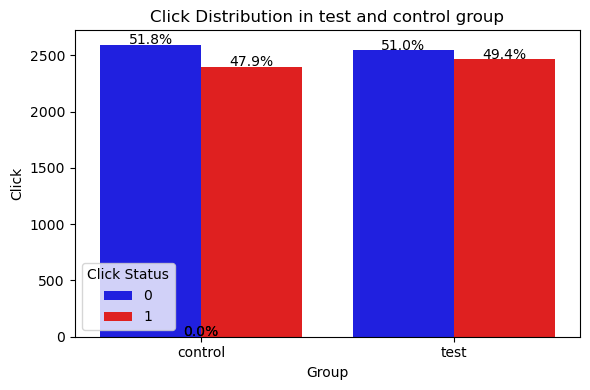

In [6]:
#plotting the click distribution for each group

plt.figure(figsize=(6,4))
ax = sns.countplot(x='group', hue='click', data=df, palette=['blue', 'red'])
plt.title("Click Distribution in test and control group")
plt.xlabel("Group")
plt.ylabel("Click")
plt.legend(title='Click Status')  


# Calculate the percentage and annotation of the bar
group_counts = df.groupby(['group']).size()
group_click_count = df.groupby(['group', 'click']).size().reset_index(name='count')

for p in ax.patches:
    height = p.get_height()
    # Find the group and click_type for current bar
    group = 'test' if p.get_x() < 0.5 else 'control'
    click = 1 if p.get_x() % 1 > 0.5 else 0
    total = group_counts.loc[group]
    percentage = 100 * height / total
    ax.text(p.get_x() + p.get_width() / 2., height + 5, f'{percentage:.1f}%', ha="center", color='black', fontsize=10)
            

# Show the plot
plt.tight_layout()            
plt.show()


## Parameter of the model from power analysis

In [7]:
alpha = 0.05 #probability of type I error
print("Alpha: significant level is:", alpha)

delta = 0.01
print("Delta: minimum detectable effect is:", delta)

Alpha: significant level is: 0.05
Delta: minimum detectable effect is: 0.01


In [8]:
#number of users per group
num_control = df[df['group'] == 'control']['click'].count()
num_test = df[df['group'] == 'test']['click'].count()

print("Total number of users in control: ", num_control)
print("Total number of users in test: ", num_test)

Total number of users in control:  4992
Total number of users in test:  5008


In [9]:
#calculate the number of clicks per group
X_control = df[df['group'] == 'control']['click'].sum()
X_test = df[df['group'] == 'test']['click'].sum()

print(df.groupby("group")["click"].sum())
print("Number of clicks in control: ", X_control)
print("Number of clicks in test: ", X_test)

group
control    2399
test       2464
Name: click, dtype: int64
Number of clicks in control:  2399
Number of clicks in test:  2464


## Calculate pooled Estimate for cick per group

In [10]:
#estimate of click probability per group
p_control = X_control/ num_control
p_test = X_test / num_test
print("click probability in control group: ", p_control)
print("click probability in test group: ", p_test)

#estimate of pooled click probability
click_prob = (X_control + X_test)/ (num_control + num_test)
print("click probability: ", click_prob)

click probability in control group:  0.48056891025641024
click probability in test group:  0.49201277955271566
click probability:  0.4863


## Calculate pooled Variance

In [11]:
#computing the estimate of the pooled variance
pooled_var = click_prob * (1 - click_prob) * (1/num_control + 1/num_test)

print("pooled Variance: ", pooled_var)


pooled Variance:  9.992517980846032e-05


## Calculate the standard error and test statistics

In [12]:
#computing the standard error of the test
SE = np.sqrt(pooled_var)
print("Standard Error is: ", SE)

#computing the test statistics of Z-test
test_stat = (p_control - p_test)/ SE
print("Test Statitics for two sample z test: ", test_stat)

# critical value of z test
Z_crit = norm.ppf(1-alpha/2)
print("Z critical value from Standard Normal Distribution: ", Z_crit)

Standard Error is:  0.00999625829040348
Test Statitics for two sample z test:  -1.144815286264828
Z critical value from Standard Normal Distribution:  1.959963984540054


## Calculate p-value of the Z-test

a low p-value (p<=0.05 at a 5% significant level) indicates strong evidence against the null hypothesis, so we reject the null hypothesis

A high p-value (p>0.05) indicates weak evidence against the hull hypothesis, so we fail to reject the null hypothesis

In [13]:
#calculate p value
p_value = 2 * norm.sf(abs(test_stat))

def statistical_significance(p_value: float, alpha: float) -> None:
    """
    Determine the statistical significance of a 2-sample Z-test.
    
    Args:
    p_value (float): The p-value.
    alpha (float): The significance level.
    """
    print(f"p-value of 2-sample Z-test: {round(p_value, 3)}")
    
    if p_value < alpha:
        print("There is statistical significance, indicating that the observed difference between the groups are unlikely to have occurred due to chance.")
    else:
        print("There is no statistical significance, suggesting that the observed difference between the groups could have occurred due to random chance.")

statistical_significance(p_value, alpha)

p-value of 2-sample Z-test: 0.252
There is no statistical significance, suggesting that the observed difference between the groups could have occurred due to random chance.


<function matplotlib.pyplot.show(close=None, block=None)>

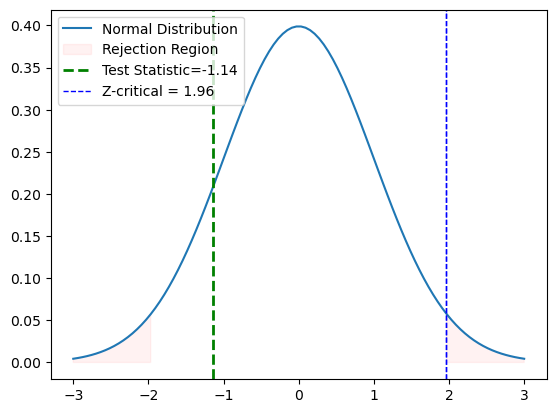

In [14]:
#paremeter for standard normal distribution
mu = 0 # mean
sigma = 1 # standard deviation
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = norm.pdf(x, mu, sigma)

# plot the normal distribution
plt.plot(x, y, label="Normal Distribution")
# shade the rejected region for a 2-tailed test
plt.fill_between(x, y, where=(x > Z_crit) | (x < -Z_crit), color="red", alpha=0.05, label="Rejection Region")
#adding test statistic
plt.axvline(test_stat, color="green", linestyle="dashed", linewidth=2, label=f'Test Statistic={test_stat:.2f}')                
#adding z-critical value
plt.axvline(Z_crit,  color="blue", linestyle="dashed", linewidth=1, label=f'Z-critical = {Z_crit:.2f}')
plt.axvline(Z_crit,  color="blue", linestyle="dashed", linewidth=1)


#Adding label and Title
plt.xlabel=("Z-value")
plt.ylabel=("Probability Density")
plt.title=("Guassian distribution with rejected region")
plt.legend()
plt.show
                

## Calculate confidence interval of the test

In [15]:
# Calculate confidence interval for a 2-sample test z-test
# calculate the lower and upper bounder for the of the cofidence interval

CI = [
    round((p_test - p_control) - SE*Z_crit, 3),
    round((p_test - p_control) + SE*Z_crit, 3)
]

# Print the calculated confidence interval
print("confidence interval of 2 sample z-test is: ", CI)
    

confidence interval of 2 sample z-test is:  [-0.008, 0.031]


In [16]:
# A/A Test Validation (Ensuring no inherent bias before testing)
a_a_p_value = stats.ttest_ind(df[df["group"] == "control"]["click"], df[df["group"] == "test"]["click"], equal_var=False).pvalue
if a_a_p_value < 0.05:
    print("Warning: A/A test shows significant difference! Check for bias in test assignment.")

## Testing for practical significance of a/b testing

In [17]:
def practical_significant(delta, CI):
    """
    we assess if the difference between the control and test group is practically significant using the minimum detectable

    Args:
    delta (float): The MDE
    CI_95 (tuple): lower bound and upper bound of the 95% confidential interval.

    Return:
    
    """
    #Extract lower bounf of 95% interval
    lower_bound_CI = CI[0]
    # Check if lower bound is greater than or equal to delta
    if lower_bound_CI >= delta:
        print("we have practical significance")
        return True
    else:
        print("We do not have a practical significance")
        return False

#calling the function
significance = practical_significant(delta, CI)
print("limit bound 95% confidence Interval is: ", CI[0])

We do not have a practical significance
limit bound 95% confidence Interval is:  -0.008
